----

-----

# 🚧 🌆 **PROJECT KAYAK** Part 🅱️ 🌇 ⛵
##### **Doriane DOYON-DOUSSE** : *Certification bloc 1* ✅  (**ds_fs_od_03** 📖) 

-----

## 🔷 **PART B.** : *Scrape Booking.com*

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

## 🔸 <ins>**1. First we will have to scrape data directly from booking.com as we don't have acces to datasets**</ins> 🔸

##### ➡️ What informations/caracterics are we going to scrape on their website :

- Hotel name,
- Url
- GPS Coordinates 
- Scores
- Text description 

#####  ➡️ Thanks to scrapping we collect datas : 
- We create our **own dataset** extrated from Booking website 


+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

### ➡️ **Importation of librairies** 📚

In [1]:
# installing web crawler : Scrapy
# -------------------------------

!pip install scrapy 

In [2]:
# Librairies for data manipulation 
import numpy as np 
import pandas as pd 
import json

# Scrapping librairies 
import scrapy 
from scrapy.crawler import CrawlerProcess 

# Storage librairie
import boto3 

# System libraies 
import os 
import logging 


### ➡️ **Reading the previous dataset** (weather data collection) 📀

In [3]:
# Lecture of the dataset 
df_weather = pd.read_csv('/Volumes/T7/__Projet 3 KAYAK __/kayak_best_5cities.csv')

# Display of it
display(df_weather)
print('------------------------------------------')

# Checking the shape 
print('Shape of the dataset : ', df_weather.shape)
print('------------------------------------------')

# Verifying dtypes from previouly
display(df_weather.dtypes) 

City   Latitude  Longitude  Temperature  Pressure  \
0             Aigues Mortes  43.566152   4.191540      8.31975  1009.900   
1                     Nimes  43.837425   4.360069      7.00950  1009.900   
2  Saintes Maries de la mer  43.451592   4.427720      8.55650  1009.600   
3                      Uzes  44.012128   4.419672      5.95250  1010.075   
4                     Paris  48.853495   2.348391      4.37150  1017.650   

   Humidity           id  
0    58.925  102716851.0  
1    60.725  102307633.0  
2    62.650  102529062.0  
3    66.025  106427400.0  
4    67.425  114827617.0

------------------------------------------
Shape of the dataset :  (5, 7)
------------------------------------------


City            object
Latitude       float64
Longitude      float64
Temperature    float64
Pressure       float64
Humidity       float64
id             float64
dtype: object

- ##### Here are just **changing the dtype of 'id'** and **'City'** columns  

In [4]:
# Modifing dtype from id column from float to int
# -----------------------------------------------
 
df_weather['id'] = df_weather['id'].astype(int)
df_weather['City'] = df_weather['City'].astype("string")
display(df_weather.dtypes) 
display(df_weather.head())

City           string[python]
Latitude              float64
Longitude             float64
Temperature           float64
Pressure              float64
Humidity              float64
id                      int64
dtype: object

City   Latitude  Longitude  Temperature  Pressure  \
0             Aigues Mortes  43.566152   4.191540      8.31975  1009.900   
1                     Nimes  43.837425   4.360069      7.00950  1009.900   
2  Saintes Maries de la mer  43.451592   4.427720      8.55650  1009.600   
3                      Uzes  44.012128   4.419672      5.95250  1010.075   
4                     Paris  48.853495   2.348391      4.37150  1017.650   

   Humidity         id  
0    58.925  102716851  
1    60.725  102307633  
2    62.650  102529062  
3    66.025  106427400  
4    67.425  114827617

### ➡️ **Scraping of the Booking.com website** 🔎

In [5]:
print('------------------------------------------------------------------------------------------------------------------')
print('   *       *       *       *        S C R A P E    B O O K I N G    H O T E L S        *       *       *       *')
print('------------------------------------------------------------------------------------------------------------------')
print()
print()

number_scraped_hotel = 10  # For each city we will scrape 10 hotel from booking
best_5_cities = df_weather['City'].to_list()[:5] # Only 5 best cities with lowest humidity rate kept 
best_5_ids = df_weather['id'].to_list()[:5] # Storing ids from best 5 cities 
id_string = 'id' # Storing id name in string

# Begin the web crawling process : we create a Spider 
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------
class BookingHotelsSpider(scrapy.Spider):

    name = "Booking_Hotels_Scraping" # named spider

    start_urls = [f'https://www.booking.com/searchresults.fr.html?ss={city}' for city in best_5_cities]  # start url loop to best 5 cities 


    def start_requests(self): # Starting requesting and trace id of 5 best cities
        for url, city_id in zip(self.start_urls, best_5_ids):
            yield scrapy.Request(url, meta={id_string: city_id})
    
    def parse(self, response): # Parsing to find best hotels from cities
        for link in response.css('h3 a[data-testid="title-link"]')[:number_scraped_hotel]:
            hotel_url = link.attrib["href"]
            yield response.follow(hotel_url, callback=self.hotel_infos, meta={id_string: response.meta[id_string]})
    
    def hotel_infos(self, response): # Parsing to gather informations from hotels
        yield {
            id_string : response.meta[id_string],
            'hotel_name' : ''.join(response.css('div.hp__hotel-title h2::text').getall()),
            'hotel_coordinates' : response.css('a#hotel_sidebar_static_map').attrib['data-atlas-latlng'],
            'hotel_score' : response.css('div[data-testid="review-score-component"] div:first-child::text').get(), 
            'hotel_description' : response.css('#property_description_content p::text').getall(),
            'hotel_url' : response.url,
        }

json_file = "scraped_hotels.json" # json file name 
path_directory = '/Volumes/T7/__Projet 3 KAYAK __' # path where results will be 
path_file = f"{path_directory}/{json_file}"
if json_file in os.listdir(path_directory): # permite to delete and update with newly scraped data if file already existing
        os.remove(path_file)


process = CrawlerProcess(settings = {   # Declaration of CrawlerProcess settings
    'USER_AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36', # Simulates a browser on an OS (my own user agent inside string)
    'LOG_LEVEL': logging.INFO, # Minimal Level of Log 
    "FEEDS": {
        path_file : {"format": "json"}, # Where the file will be stored (in format json)
    },
    "AUTOTHROTTLE_ENABLED": True  # Avoid being detected as fraud and banned (slowing speed of the scrapping)
})

# Start crawling 
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------
process.crawl(BookingHotelsSpider) # Start crawling 
process.start()

print()
print()
print('------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------')


2024-01-05 00:28:37 [scrapy.utils.log] INFO: Scrapy 2.11.0 started (bot: scrapybot)
2024-01-05 00:28:37 [scrapy.utils.log] INFO: Versions: lxml 4.9.3.0, libxml2 2.10.3, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.2, Twisted 22.10.0, Python 3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)], pyOpenSSL 23.2.0 (OpenSSL 3.1.3 19 Sep 2023), cryptography 41.0.4, Platform macOS-13.6.1-arm64-arm-64bit
2024-01-05 00:28:37 [scrapy.addons] INFO: Enabled addons:
[]
2024-01-05 00:28:37 [py.warnings] WARNING: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scrapy/utils/request.py:254: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future v

------------------------------------------------------------------------------------------------------------------
   *       *       *       *        S C R A P E    B O O K I N G    H O T E L S        *       *       *       *
------------------------------------------------------------------------------------------------------------------




2024-01-05 00:29:37 [scrapy.extensions.logstats] INFO: Crawled 47 pages (at 47 pages/min), scraped 42 items (at 42 items/min)
2024-01-05 00:29:45 [scrapy.core.engine] INFO: Closing spider (finished)
2024-01-05 00:29:45 [scrapy.extensions.feedexport] INFO: Stored json feed (50 items) in: /Volumes/T7/__Projet 3 KAYAK __/scraped_hotels.json
2024-01-05 00:29:45 [scrapy.statscollectors] INFO: Dumping Scrapy stats:
{'downloader/request_bytes': 76288,
 'downloader/request_count': 55,
 'downloader/request_method_count/GET': 55,
 'downloader/response_bytes': 18053621,
 'downloader/response_count': 55,
 'downloader/response_status_count/200': 55,
 'elapsed_time_seconds': 67.941589,
 'feedexport/success_count/FileFeedStorage': 1,
 'finish_reason': 'finished',
 'finish_time': datetime.datetime(2024, 1, 4, 23, 29, 45, 324532, tzinfo=datetime.timezone.utc),
 'httpcompression/response_bytes': 75215139,
 'httpcompression/response_count': 55,
 'item_scraped_count': 50,
 'log_count/INFO': 12,
 'log_coun



------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------


### ➡️ **Open json obtained from scrapping & put it into a DF** 🔎📥

In [6]:
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------')
print(' *       *       *       *       *        *         D A T A S E T    O B T A I N E D    F R O M    S C R A P I N G          *       *       *       *       *        *  ')
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
print()

# Opening and loading the json file obtained from Booking Scraping 
# ----------------------------------------------------------------------------------------
with open("/Volumes/T7/__Projet 3 KAYAK __/scraped_hotels.json", 'r') as scraped_hotels:
    json_scraped_hotels = json.load(scraped_hotels)

# Create a dataframe from the file 
# ----------------------------------------------------------------------------------------
df_scraped_hotels = pd.DataFrame(json_scraped_hotels)

# Display of the dataframe 
# ----------------------------------------------------------------------------------------
print('Display of the dataset : ')
display(df_scraped_hotels)


# Shape of the dataframe 
# ----------------------------------------------------------------------------------------
print('Shape of the dataset is : ', df_scraped_hotels.shape)
print()


# Columns of the dataframe 
# ----------------------------------------------------------------------------------------
print('Column name of the dataset : ', df_scraped_hotels.columns)
print()

# Informations of the dataframe 
# ----------------------------------------------------------------------------------------
print('Informations of the dataset  : ')
display(df_scraped_hotels.info())

print()
print()
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------')


-------------------------------------------------------------------------------------------------------------------------------------------------------------
 *       *       *       *       *        *         D A T A S E T    O B T A I N E D    F R O M    S C R A P I N G          *       *       *       *       *        *  
-------------------------------------------------------------------------------------------------------------------------------------------------------------


Display of the dataset : 


id                                         hotel_name  \
0   102716851                          Hotel Canal Aigues Mortes   
1   102716851                           Notre cocon des remparts   
2   102716851               Résidence Odalys Le Mas des Flamants   
3   102716851                                  Hôtel Le Médiéval   
4   102716851                                  La Maison de Lyna   
5   102716851                                  Hôtel Saint Louis   
6   102716851                      Résidence Odalys Fleur de Sel   
7   102716851                                   La Villa Mazarin   
8   102716851                               Maison des Croisades   
9   102307633                                        Royal Hôtel   
10  102307633                                     escale evasion   
11  102716851                                  le dit vin secret   
12  102307633                                     Hotel Majestic   
13  102307633             Zenitude Hôtel-Résidences Nîmes Centre   
14  102529062          Mas du Couvin, maison d'hôtes en Camargue   
15  106427400    UZES APPART HOTEL Résidence Le Mas des Oliviers   
16  114827617                        Austin's Saint Lazare Hotel   
17  114827617                          1er Etage SoPi-Montmartre   
18  114827617                                     Maison Eugenie   
19  114827617                     B&B HOTEL Paris 17 Batignolles   
20  114827617                                       Hôtel Aiglon   
21  114827617                                Hôtel Korner Etoile   
22  114827617                               Hotel de L'Esperance   
23  114827617                                   Le Katorze Hôtel   
24  114827617                                      Hôtel Le Daum   
25  114827617                    UCPA SPORT STATION HOSTEL PARIS   
26  106427400                                   La DAME de FLAUX   
27  106427400                                 Appartement Ulysse   
28  106427400                                    Le trente trois   
29  106427400  appartement 3 min a pied du centre d'Uzès park...   
30  106427400                              Hôtel Le Saint-Geniès   
31  106427400  Appartement moderne central avec piscine, gara...   
32  106427400                         Chambre Hôte vue splendide   
33  106427400                                         La Taverne   
34  106427400                          Boutique Hôtel Entraigues   
35  102529062                                      Hotel Camille   
36  102529062                                  Hôtel Les Arcades   
37  102529062                                      La Tramontane   
38  102529062                     Hotel Les Palmiers En Camargue   
39  102529062                                    Le Dauphin Bleu   
40  102529062                                  Thalacap Camargue   
41  102529062                              Hotel Le Méditérranée   
42  102529062                                  Hôtel Casa Marina   
43  102529062                               Hotel Le Bleu Marine   
44  102307633                           Odalys City Nîmes Arènes   
45  102307633                Twenty Business Flats Nîmes Trigone   
46  102307633                                hotelF1 Nîmes Ouest   
47  102307633                           Logis NIMOTEL Hôtel Cosy   
48  102307633                    Maison Albar Hotels L’Imperator   
49  102307633                Appart'City Collection Nîmes Arènes   

         hotel_coordinates hotel_score  \
0   43.57298752,4.19482470         8,5   
1   43.56753020,4.19419340        None   
2   43.57379435,4.18062186         8,1   
3   43.57186625,4.19366169         8,6   
4   43.56601750,4.19235320         9,1   
5   43.56721967,4.18934360         8,4   
6   43.57409400,4.17924600         8,3   
7   43.56498662,4.19175196         9,2   
8   43.56899740,4.18829820         8,8   
9   43.83881510,4.35481846         8,3   
10  43.81506220,4.33594350        None   
11  43.56676900,4.18911300         8,6

Shape of the dataset is :  (50, 6)

Column name of the dataset :  Index(['id', 'hotel_name', 'hotel_coordinates', 'hotel_score',
       'hotel_description', 'hotel_url'],
      dtype='object')

Informations of the dataset  : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 50 non-null     int64 
 1   hotel_name         50 non-null     object
 2   hotel_coordinates  50 non-null     object
 3   hotel_score        47 non-null     object
 4   hotel_description  50 non-null     object
 5   hotel_url          50 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.5+ KB


None



-------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------


### ➡️ **Cleaning data** 🔩

In [7]:
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------')
print(' *       *       *       *       *        *        P R E P R O C E S S I N G    U N C L E A N    D A T A         *       *       *       *       *        *  ')
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
print()

print('-----------------------------------------------------------  Starting cleaning data ... ----------------------------------------------------------')
print()

# Seperating into two different columns ('hotel_latitude' and 'hotel_longitude') the ancien one scrapped ('hotel_coordinates')
df_scraped_hotels['hotel_latitude'] = df_scraped_hotels['hotel_coordinates'].str.split(',').apply(lambda x: x[0]).astype(float)
df_scraped_hotels['hotel_longitude'] = df_scraped_hotels['hotel_coordinates'].str.split(',').apply(lambda x: x[1]).astype(float)
df_scraped_hotels = df_scraped_hotels.drop(columns = ['hotel_coordinates'])

# Replacing commas by dots in column with Reviews Score and changing the type to foat 
df_scraped_hotels['hotel_score'] = df_scraped_hotels['hotel_score'].str.replace(',','.')
df_scraped_hotels['hotel_score'] = df_scraped_hotels['hotel_score'].astype(float)

# Joining description 
df_scraped_hotels['hotel_description'] = df_scraped_hotels['hotel_description'].str.join('') 

print('----------------------------------------------------------- ... data cleaning is done! -----------------------------------------------------------')
print()
print()

print('        . . . . . . . . . . . . . . . . . . . . . . . . . . Display of the cleaned dataset : . . . . . . . . . . . . . . . . . . . . . . . . . . ')
print()
display(df_scraped_hotels)

print()
print()
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------------------------------------------------------------------------
 *       *       *       *       *        *        P R E P R O C E S S I N G    U N C L E A N    D A T A         *       *       *       *       *        *  
-------------------------------------------------------------------------------------------------------------------------------------------------------------


Starting cleaning data ...

... data cleaning is done!

Display of the cleaned dataset : 



id                                         hotel_name  hotel_score  \
0   102716851                          Hotel Canal Aigues Mortes          8.5   
1   102716851                           Notre cocon des remparts          NaN   
2   102716851               Résidence Odalys Le Mas des Flamants          8.1   
3   102716851                                  Hôtel Le Médiéval          8.6   
4   102716851                                  La Maison de Lyna          9.1   
5   102716851                                  Hôtel Saint Louis          8.4   
6   102716851                      Résidence Odalys Fleur de Sel          8.3   
7   102716851                                   La Villa Mazarin          9.2   
8   102716851                               Maison des Croisades          8.8   
9   102307633                                        Royal Hôtel          8.3   
10  102307633                                     escale evasion          NaN   
11  102716851                                  le dit vin secret          8.6   
12  102307633                                     Hotel Majestic          8.3   
13  102307633             Zenitude Hôtel-Résidences Nîmes Centre          7.9   
14  102529062          Mas du Couvin, maison d'hôtes en Camargue          9.6   
15  106427400    UZES APPART HOTEL Résidence Le Mas des Oliviers          7.5   
16  114827617                        Austin's Saint Lazare Hotel          8.1   
17  114827617                          1er Etage SoPi-Montmartre          9.0   
18  114827617                                     Maison Eugenie          8.1   
19  114827617                     B&B HOTEL Paris 17 Batignolles          7.9   
20  114827617                                       Hôtel Aiglon          8.7   
21  114827617                                Hôtel Korner Etoile          8.3   
22  114827617                               Hotel de L'Esperance          8.5   
23  114827617                                   Le Katorze Hôtel          8.4   
24  114827617                                      Hôtel Le Daum          8.4   
25  114827617                    UCPA SPORT STATION HOSTEL PARIS          8.0   
26  106427400                                   La DAME de FLAUX          9.7   
27  106427400                                 Appartement Ulysse          9.5   
28  106427400                                    Le trente trois          8.9   
29  106427400  appartement 3 min a pied du centre d'Uzès park...          8.8   
30  106427400                              Hôtel Le Saint-Geniès          8.8   
31  106427400  Appartement moderne central avec piscine, gara...          9.3   
32  106427400                         Chambre Hôte vue splendide          8.8   
33  106427400                                         La Taverne          8.6   
34  106427400                          Boutique Hôtel Entraigues          8.9   
35  102529062                                      Hotel Camille          8.0   
36  102529062                                  Hôtel Les Arcades          8.6   
37  102529062                                      La Tramontane          9.0   
38  102529062                     Hotel Les Palmiers En Camargue          8.0   
39  102529062                                    Le Dauphin Bleu          8.4   
40  102529062                                  Thalacap Camargue          7.8   
41  102529062                              Hotel Le Méditérranée          7.3   
42  102529062                                  Hôtel Casa Marina          8.9   
43  102529062                               Hotel Le Bleu Marine          7.6   
44  102307633                           Odalys City Nîmes Arènes          NaN   
45  102307633                Twenty Business Flats Nîmes Trigone          8.3   
46  102307633                                hotelF1 Nîmes Ouest          6.5   
47  102307633                           Logis NIMOTEL Hôtel Cosy          7.7   
48  102307633                    Maison Al



-------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------


### ➡️ **Merging both weather and scraped hotel dataframes** 🔎📥

In [14]:
merged_df = df_weather.merge(df_scraped_hotels, how = 'left', on = 'id') 
merged_df.head()

City   Latitude  Longitude  Temperature  Pressure  Humidity  \
0  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   
1  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   
2  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   
3  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   
4  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   

          id                            hotel_name  hotel_score  \
0  102716851             Hotel Canal Aigues Mortes          8.5   
1  102716851              Notre cocon des remparts          NaN   
2  102716851  Résidence Odalys Le Mas des Flamants          8.1   
3  102716851                     Hôtel Le Médiéval          8.6   
4  102716851                     La Maison de Lyna          9.1   

                                   hotel_description  \
0  Vous pouvez bénéficier d'une réduction Genius ...   
1  Situé à Aigues-Mortes, le Notre cocon des remp...   
2  Située à l'extérieur des fortifications d'Aigu...   
3  Vous pouvez bénéficier d'une réduction Genius ...   
4  Vous pouvez bénéficier d'une réduction Genius ...   

                                           hotel_url  hotel_latitude  \
0  https://www.booking.com/hotel/fr/canal-aigues-...       43.572988   
1  https://www.booking.com/hotel/fr/notre-cocon-d...       43.567530   
2  https://www.booking.com/hotel/fr/residence-le-...       43.573794   
3  https://www.booking.com/hotel/fr/le-medieval.f...       43.571866   
4  https://www.booking.com/hotel/fr/la-maison-de-...       43.566018   

   hotel_longitude  
0         4.194825  
1         4.194193  
2         4.180622  
3         4.193662  
4         4.192353

### ➡️ **Looking on a map top hotels with best weather humidity conditions** ✅

In [16]:
merged_df.dtypes

City                 string[python]
Latitude                    float64
Longitude                   float64
Temperature                 float64
Pressure                    float64
Humidity                    float64
id                            int64
hotel_name                   object
hotel_score                 float64
hotel_description            object
hotel_url                    object
hotel_latitude              float64
hotel_longitude             float64
dtype: object

In [43]:
# Changing hotel_score dtype from object to float (to plot it)
#-------------------------------------------------------------
merged_df['hotel_score'] = merged_df['hotel_score'].astype(float)
print(merged_df['hotel_score'].dtypes)

float64


In [44]:
import plotly.express as px 

#### Do not hesitate to **click on different cities** and **zoom and move around the map** (open upper left part of the graph) 👀

In [61]:
fig = px.scatter_mapbox(merged_df, 
                        lat = "hotel_latitude", 
                        lon = "hotel_longitude", 
                        color='Humidity',
                        size='Humidity',
                        mapbox_style='carto-positron',
                        opacity = 0.8, 
                        width=1200, 
                        height=1200, 
                        zoom=5,
                        title = 'Localising top hotels scores where humidity conditions')

fig.show('vscode')
fig.write_html("1_final_picture_HOTELS&WEATHER.html")

##  📌 **Visualizing on a map best hotels matching with optimal humidity rate** 

### 📎 **All hotels, all cities** 

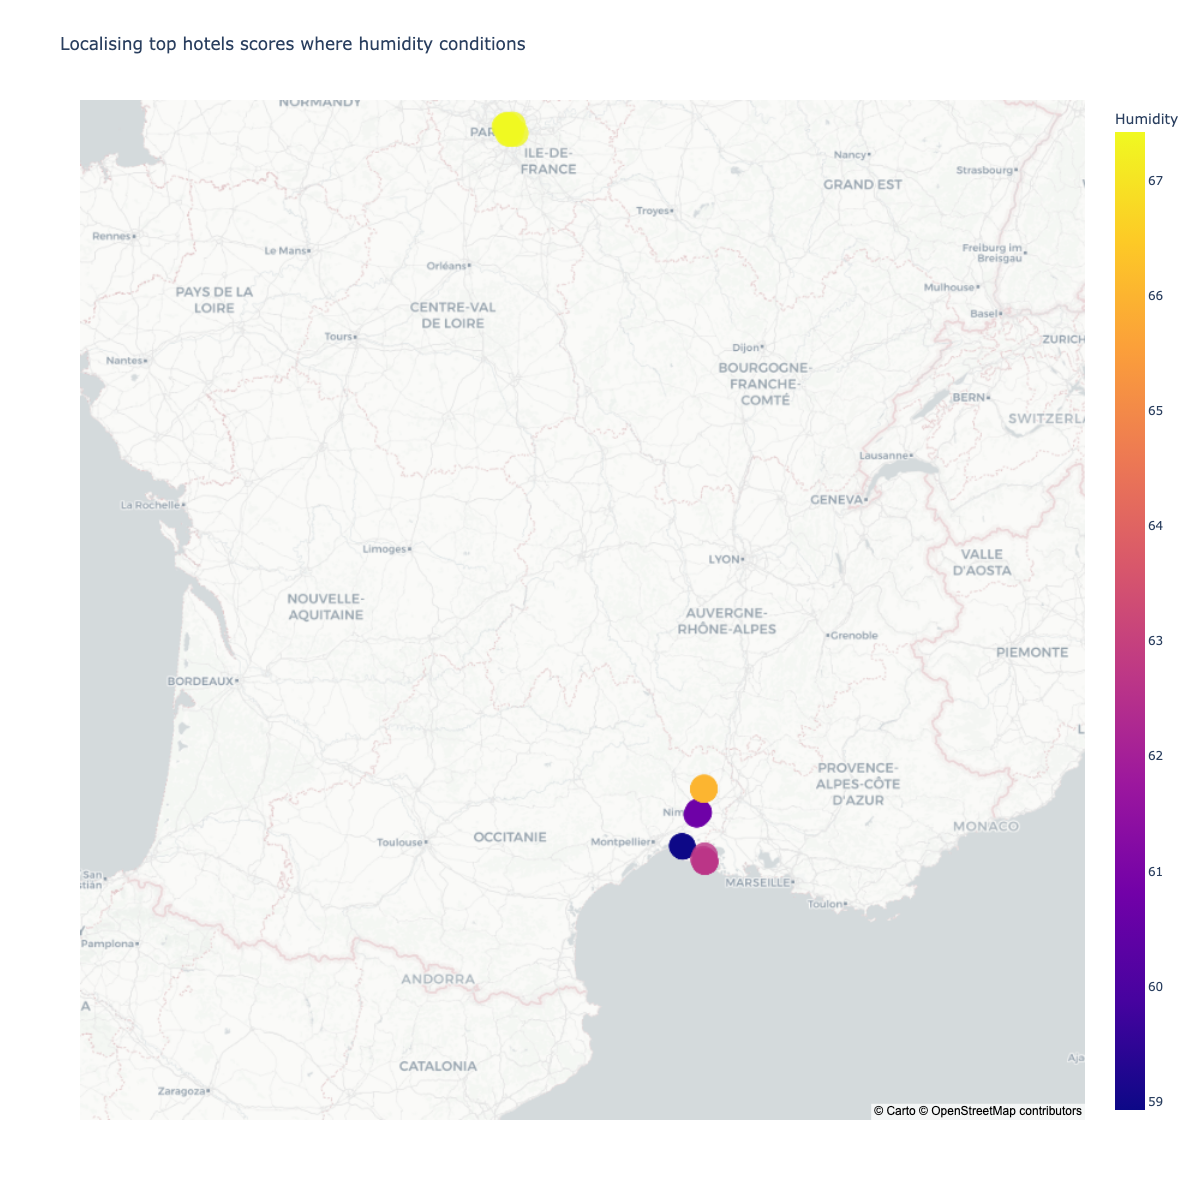

In [1]:
from IPython.display import Image
Image(filename="Graphs/AllTopHotels_5cities.png")

# 📎 **Let's have a closer look at every cities best hotels** (static images)

## 📌 **AIGUES MORTES** 📌

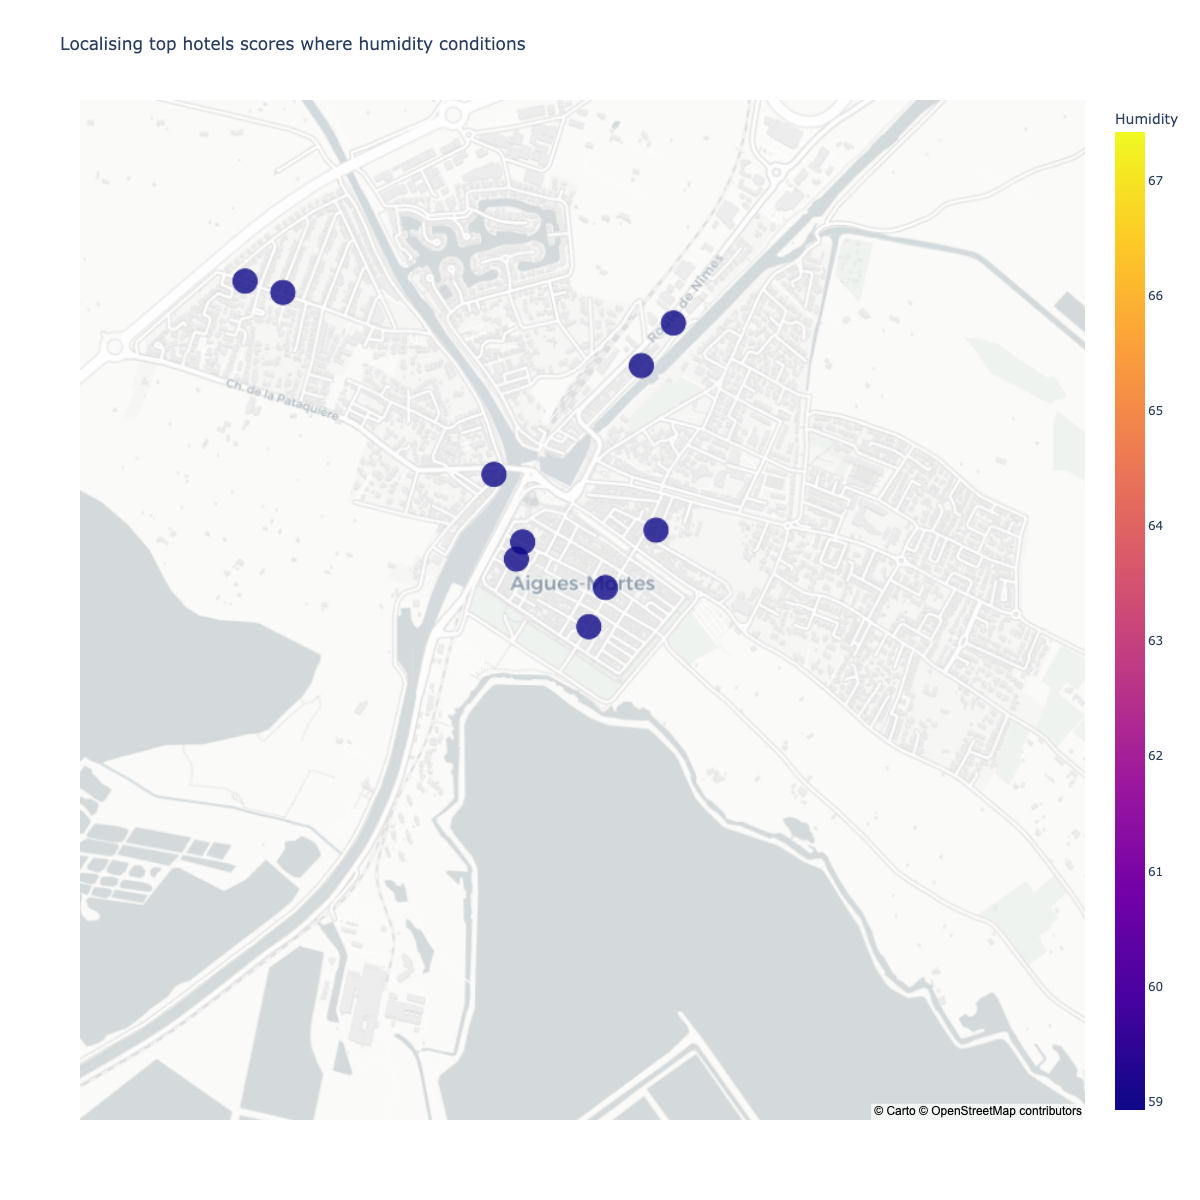

In [2]:
from IPython.display import Image
Image(filename="Graphs/TopHotels_AiguesMortes.png")

## 📌 **NIMES** 📌

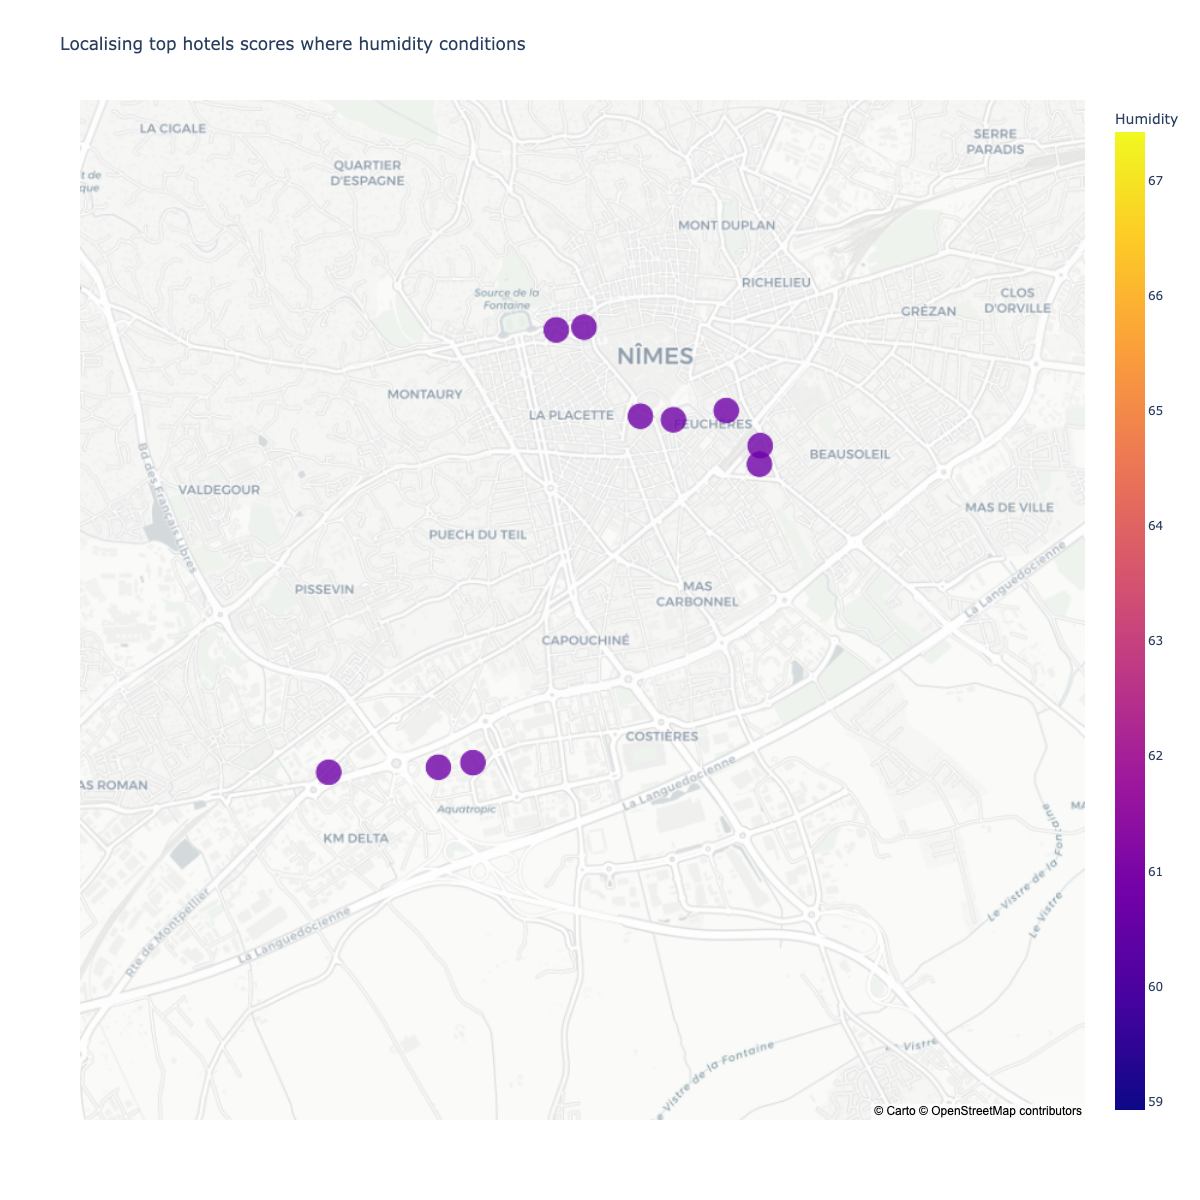

In [4]:
from IPython.display import Image
Image(filename="Graphs/TopHotels_Nimes.png")

## 📌 **PARIS** 📌

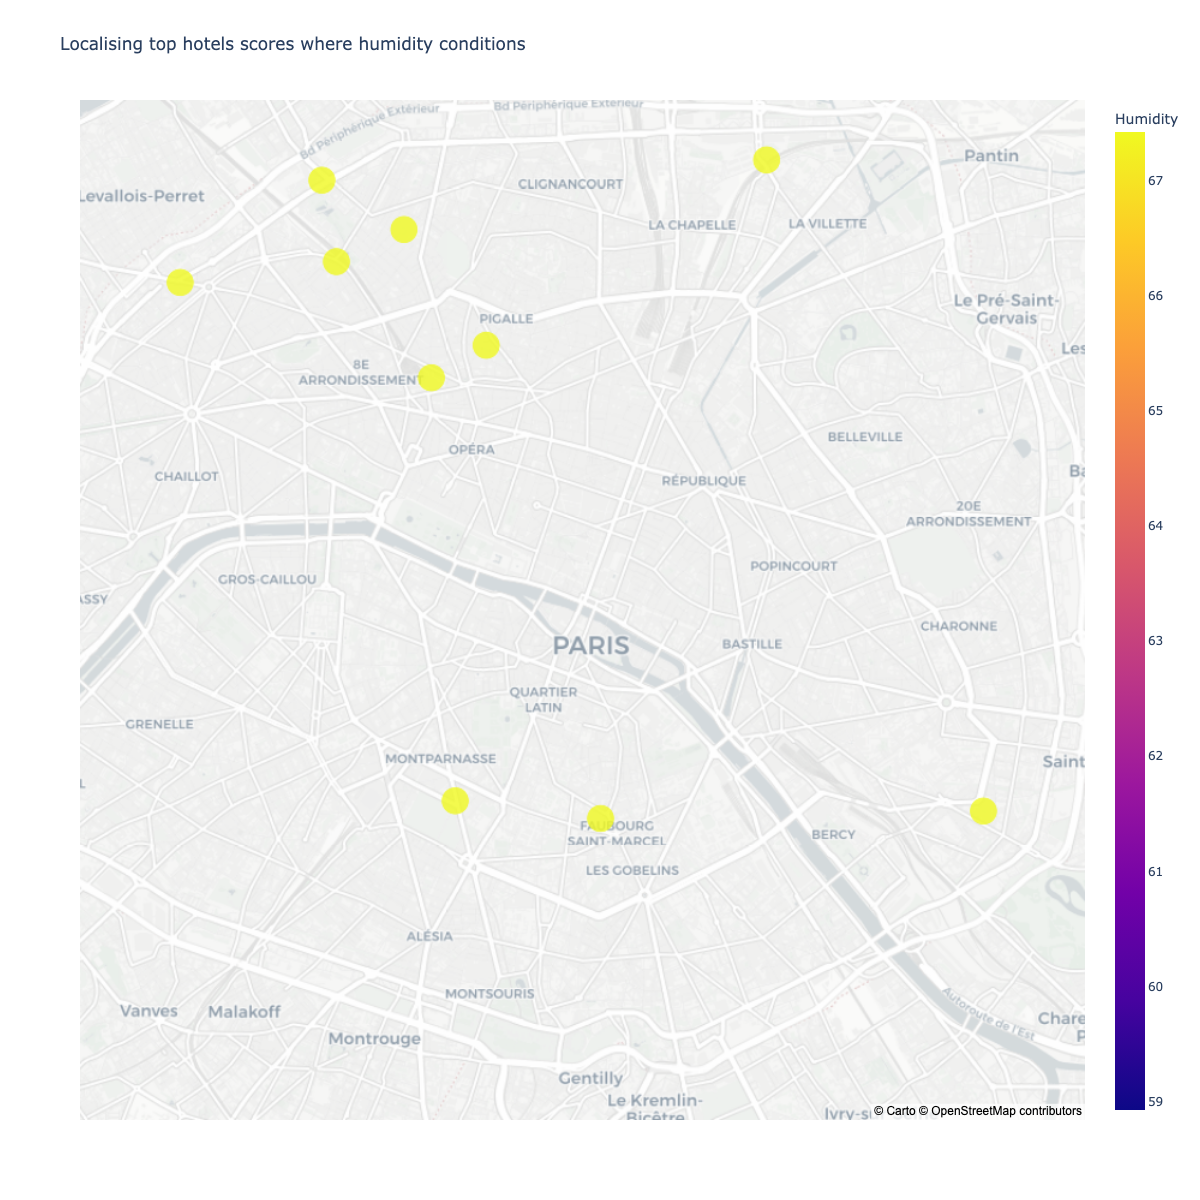

In [5]:
from IPython.display import Image
Image(filename="Graphs/TopHotels_Paris.png")

## 📌 **SAINTE MARIE LA MER** 📌

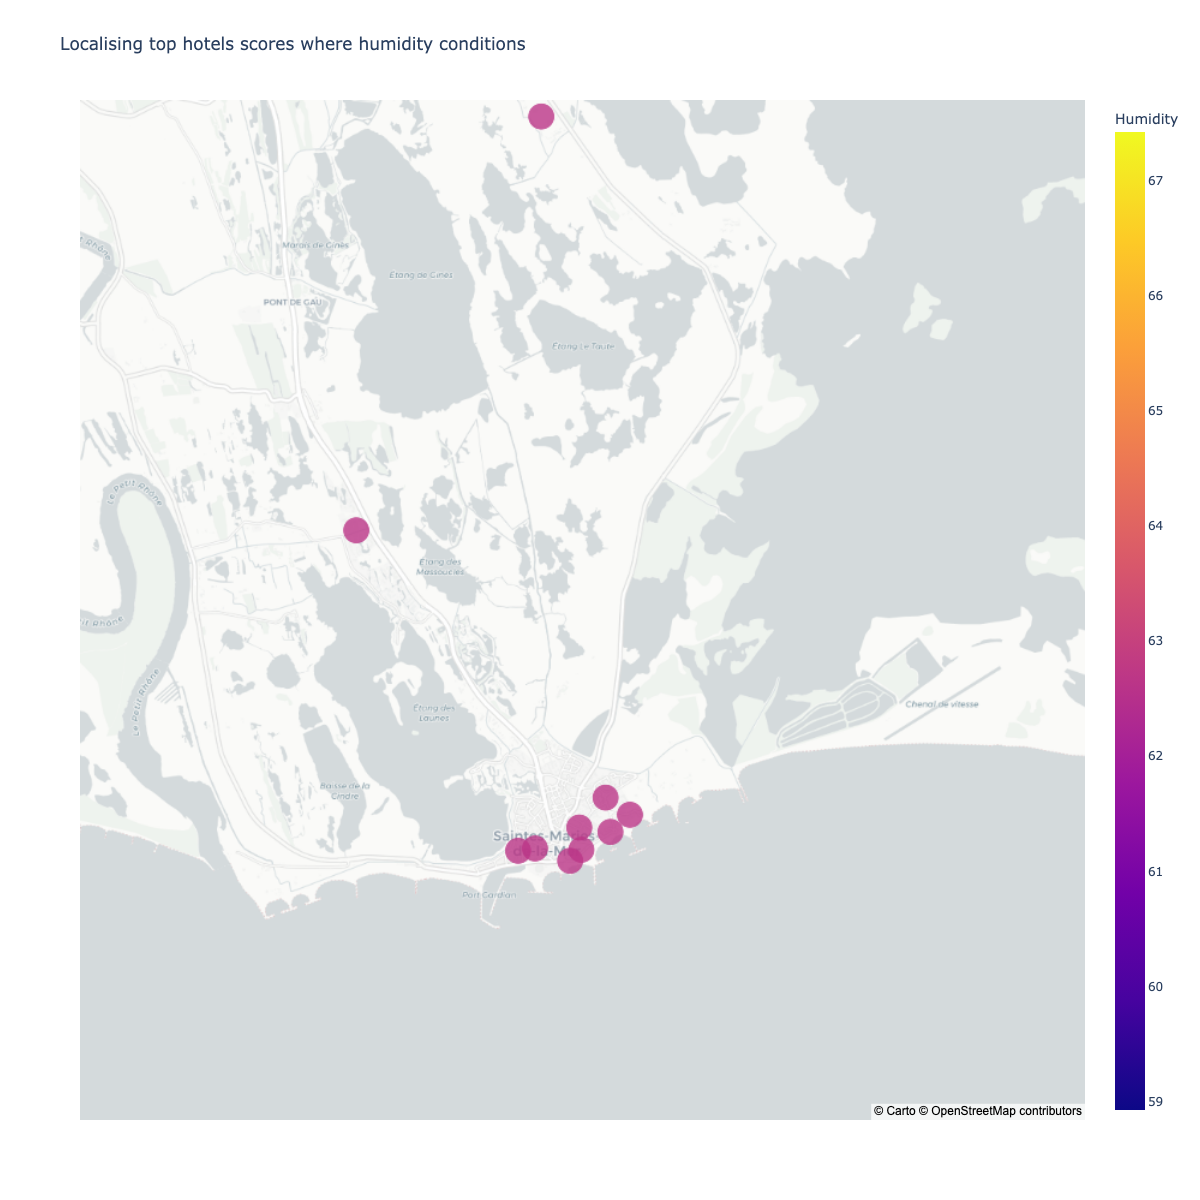

In [6]:
from IPython.display import Image
Image(filename="Graphs/TopHotels_SainteMarie.png")

## 📌 **UZES** 📌

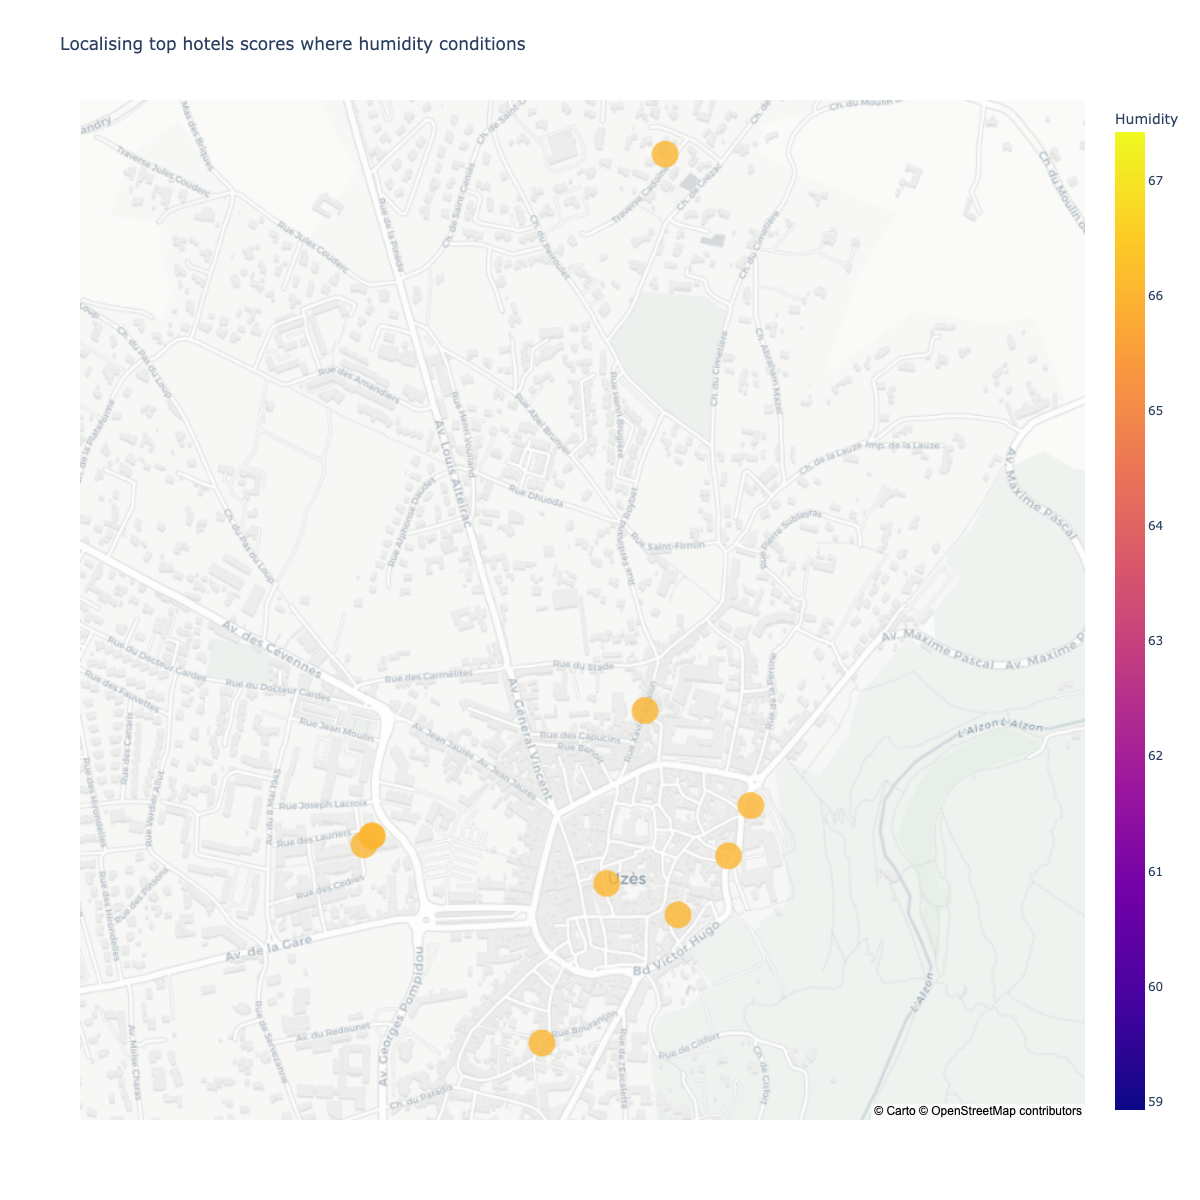

In [7]:
from IPython.display import Image
Image(filename="Graphs/TopHotels_Uzes.png")

In [60]:
# Adding animanition frame argument which permits to select a city
# ------------------------------------------------------------------------------------------


fig = px.scatter_mapbox(merged_df, 
                        lat = "hotel_latitude", 
                        lon = "hotel_longitude", 
                        color='hotel_name',
                        size='Humidity',
                        animation_frame= 'City',
                        mapbox_style='carto-positron',
                        opacity = 0.8, 
                        width=1200, 
                        height=1200, 
                        zoom=6,
                        title = 'Localising top hotels scores where humidity conditions')

fig.show('vscode')
fig.write_html("2_final_picture_HOTELS&WEATHER.html")

### **Top 9 hotels matching best humidity rate for arthritis** : Aigues Mortes is the winner city 👀

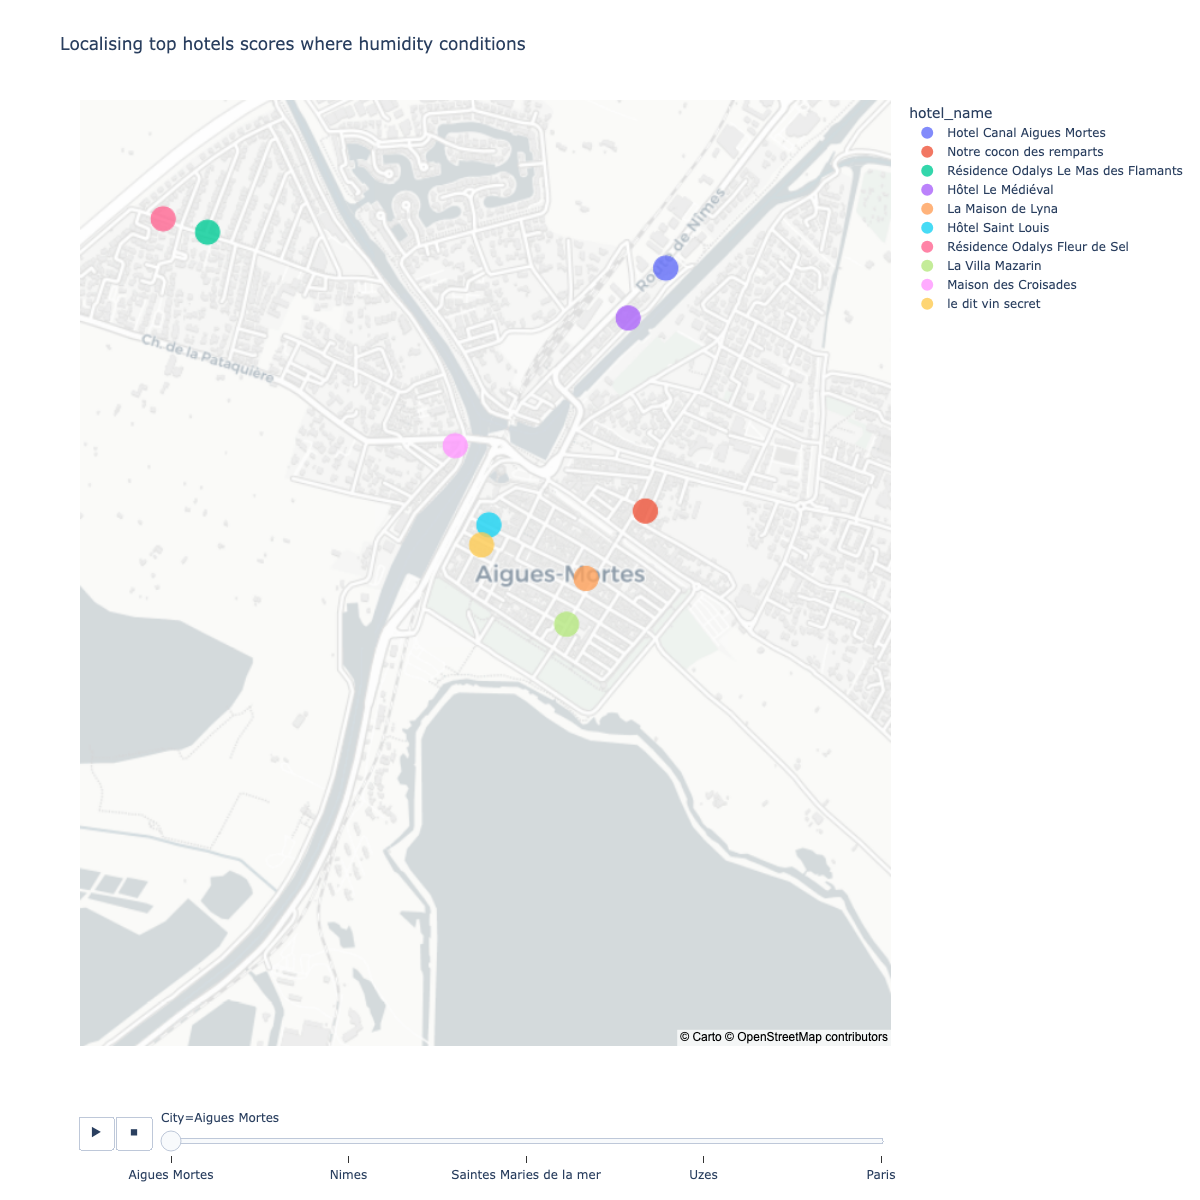

In [8]:
from IPython.display import Image
Image(filename="Graphs/AigueMortes_BestHotels.png")

In [63]:
# Keeping the final csv file locally
#-----------------------------------------------------
path = "/Volumes/T7/__Projet 3 KAYAK __/merge_df.csv"
merged_df.to_csv(path, index = False) 

---

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

## 🔸 <ins>**2. Second task will be to create a data lake using S3**</ins> 🔸


##### ➡️ We store our data in Amazon S3 :
- We will have to load it a csv file.

In [ ]:
file_name = 'merge_df.csv'
region = 'eu-west-3'

ACCESS_KEY_ID = "ACCESS_KEY_ID"
SECRET_ACCESS_KEY = "SECRET_ACCESS_KEY"

session = boto3.Session(aws_access_key_id=ACCESS_KEY_ID, 
                        aws_secret_access_key=SECRET_ACCESS_KEY)
s3 = session.client("s3")
bucket_name = 'project_scraping_doriane'

try: # Create the bucket if not already existing
    bucket = s3.create_bucket(Bucket = bucket_name, CreateBucketConfiguration = {'LocationConstraint': region}) # if the bucket does not already exists, create it
except (s3.exceptions.BucketAlreadyExists, s3.exceptions.BucketAlreadyOwnedByYou) as err:
    print("Bucket already existing.")

s3.put_object(Bucket = bucket_name, Body = merged_df.to_csv(index = False), Key = file_name) 
s3.put_object_acl(ACL="public-read", Bucket = bucket_name, Key = file_name) 

Now that the bucket as been created, I manually load the merge_df inside it and gave public access to it so anybody can retrive scrapped data.

---

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 

# 🔸 <ins>**3. ETL process**</ins> (Extract Transform Load)🔸


## ◾️ <ins>**EXTRACT**</ins> 📌

° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° °

##### <ins>*➡️ Let's extract our Dataset from S3 bucket URL ✅*</ins>

In [29]:
%pip install pip-system-certs

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


In [30]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [44]:
# Testing if the URL from S3 is accessible 
# ---------------------------------------------------------------------------------------------------------------------------
import pandas as pd 
test_df_s3 = pd.read_csv("https://project-scraping-doshdyndss-jedha-certification.s3.eu-west-3.amazonaws.com/merge_df.csv")
test_df_s3.head()

City   Latitude  Longitude  Temperature  Pressure  Humidity  \
0  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   
1  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   
2  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   
3  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   
4  Aigues Mortes  43.566152    4.19154      8.31975    1009.9    58.925   

          id                            hotel_name  hotel_score  \
0  102716851             Hotel Canal Aigues Mortes          8.5   
1  102716851              Notre cocon des remparts          NaN   
2  102716851  Résidence Odalys Le Mas des Flamants          8.1   
3  102716851                     Hôtel Le Médiéval          8.6   
4  102716851                     La Maison de Lyna          9.1   

                                   hotel_description  \
0  Vous pouvez bénéficier d'une réduction Genius ...   
1  Situé à Aigues-Mortes, le Notre cocon des remp...   
2  Située à l'extérieur des fortifications d'Aigu...   
3  Vous pouvez bénéficier d'une réduction Genius ...   
4  Vous pouvez bénéficier d'une réduction Genius ...   

                                           hotel_url  hotel_latitude  \
0  https://www.booking.com/hotel/fr/canal-aigues-...       43.572988   
1  https://www.booking.com/hotel/fr/notre-cocon-d...       43.567530   
2  https://www.booking.com/hotel/fr/residence-le-...       43.573794   
3  https://www.booking.com/hotel/fr/le-medieval.f...       43.571866   
4  https://www.booking.com/hotel/fr/la-maison-de-...       43.566018   

   hotel_longitude  
0         4.194825  
1         4.194193  
2         4.180622  
3         4.193662  
4         4.192353

## ◾️ <ins>**TRANSFORM**</ins> 📌

° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° °

* As the team asked us to be able to get data obtained from our work, we need to transform data in order to give something clean before putting it in a Database.
* Let's check if the data is clean, jsut in case we missed something.

In [19]:
# Let's check the datatypes from the s3 dataframe
# ---------------------------------------------------------------------------------------------------------------------------
test_df_s3.dtypes

City                  object
Latitude             float64
Longitude            float64
Temperature          float64
Pressure             float64
Humidity             float64
id                     int64
hotel_name            object
hotel_score          float64
hotel_description     object
hotel_url             object
hotel_latitude       float64
hotel_longitude      float64
dtype: object

In [20]:
# Changing the dtype of the 'City' column : from object to string 
# ---------------------------------------------------------------------------------------------------------------------------
test_df_s3['City'] = test_df_s3['City'].astype("string")
display(test_df_s3.dtypes) 

City                 string[python]
Latitude                    float64
Longitude                   float64
Temperature                 float64
Pressure                    float64
Humidity                    float64
id                            int64
hotel_name                   object
hotel_score                 float64
hotel_description            object
hotel_url                    object
hotel_latitude              float64
hotel_longitude             float64
dtype: object

In [28]:
# We alrealdy cleaned the Dataframe before loading it in a s3 bucket but let's check duplicates, just in case
# ---------------------------------------------------------------------------------------------------------------------------
number_of_duplicates = test_df_s3.duplicated().sum()
print("Number of duplicates :", number_of_duplicates)

if number_of_duplicates == 0: 
    print('------------------------------------------------')
    print('Yay! No duplicates detected.')
else :
    print('Some duplicates have been detected, remove them.')

Number of duplicates : 0
------------------------------------------------
Yay! No duplicates detected.


In [47]:
# Are there missing values still present ? 
# ---------------------------------------------------------------------------------------------------------------------------
print("Are there missing values in the dataset ?", test_df_s3.isnull().values.any())


Are there missing values in the dataset ? True


In [46]:
# Describe our dataset : where are the missing values (let's take a look at the count)
# ---------------------------------------------------------------------------------------------------------------------------
test_df_s3.describe()

Latitude  Longitude  Temperature     Pressure  Humidity            id  \
count  50.000000  50.000000    50.000000    50.000000  50.00000  5.000000e+01   
mean   44.744158   3.949478     6.841950  1011.425000  63.15000  1.057617e+08   
std     2.085083   0.813214     1.567911     3.147886   3.21103  4.829451e+06   
min    43.451592   2.348391     4.371500  1009.600000  58.92500  1.023076e+08   
25%    43.566152   4.191540     5.952500  1009.900000  60.72500  1.025291e+08   
50%    43.837425   4.360069     7.009500  1009.900000  62.65000  1.027169e+08   
75%    44.012128   4.419672     8.319750  1010.075000  66.02500  1.064274e+08   
max    48.853495   4.427720     8.556500  1017.650000  67.42500  1.148276e+08   

       hotel_score  hotel_latitude  hotel_longitude  
count    45.000000       50.000000        50.000000  
mean      8.455556       44.748566         3.944346  
std       0.645458        2.087959         0.818250  
min       6.500000       43.450352         2.288388  
25%       8.100000       43.566882         4.188502  
50%       8.500000       43.833183         4.360212  
75%       8.900000       44.012310         4.417563  
max       9.600000       48.889975         4.435596

Okay so when you are looking at the description up there, we can see in the "count" that **missing values are in Hotel Score** : 4 scores are missing.

In [52]:
# Removal of lines with hotel scores 
# ---------------------------------------------------------------------------------------------------------------------------
df_cleaned = test_df_s3.dropna()
print("Are there missing values in the dataset ?", df_cleaned.isnull().values.any())
display(df_cleaned.describe())

Are there missing values in the dataset ? False


Latitude  Longitude  Temperature     Pressure   Humidity  \
count  45.000000  45.000000    45.000000    45.000000  45.000000   
mean   44.851744   3.903450     6.806817  1011.593333  63.181111   
std     2.171917   0.844920     1.607295     3.277499   3.249717   
min    43.451592   2.348391     4.371500  1009.600000  58.925000   
25%    43.566152   4.191540     5.952500  1009.900000  60.725000   
50%    43.837425   4.360069     7.009500  1009.900000  62.650000   
75%    44.012128   4.419672     8.319750  1010.075000  66.025000   
max    48.853495   4.427720     8.556500  1017.650000  67.425000   

                 id  hotel_score  hotel_latitude  hotel_longitude  
count  4.500000e+01    45.000000       45.000000        45.000000  
mean   1.059484e+08     8.455556       44.856987         3.897725  
std    5.019847e+06     0.645458        2.174617         0.849996  
min    1.023076e+08     6.500000       43.450352         2.288388  
25%    1.025291e+08     8.100000       43.566769         4.180622  
50%    1.027169e+08     8.500000       43.832493         4.358018  
75%    1.064274e+08     8.900000       44.012633         4.417885  
max    1.148276e+08     9.600000       48.889975         4.435451

Perfect! No missing values, no duplicates, the dataframe is cleaned and ready to create our DataBase with sqlite3

## ◾️ <ins>**LOAD**</ins> 📌

° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° ° °

### <ins>Creation of a database with **sqlite3**</ins> 🟤

In [69]:
# Modifying datatypes of df_cleaned in order to simplify database creation
# ---------------------------------------------------------------------------------------------------------------------------
df_cleaned['City'] = df_cleaned.loc[:, 'City'].astype("string")
df_cleaned['hotel_url'] = df_cleaned.loc[:, 'hotel_url'].astype("string")
df_cleaned['hotel_description'] = df_cleaned.loc[:, 'hotel_description'].astype("string")
df_cleaned['hotel_name'] = df_cleaned.loc[:, 'hotel_name'].astype("string")
display(df_cleaned.dtypes) 

/var/folders/qv/htbcx5kd457215x3wg_q3d6m0000gn/T/ipykernel_67635/3433280817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['City'] = df_cleaned.loc[:, 'City'].astype("string")
/var/folders/qv/htbcx5kd457215x3wg_q3d6m0000gn/T/ipykernel_67635/3433280817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['hotel_url'] = df_cleaned.loc[:, 'hotel_url'].astype("string")
/var/folders/qv/htbcx5kd457215x3wg_q3d6m0000gn/T/ipykernel_67635/3433280817.py:5: SettingWithCopyWarning: 
A value is 

City                 string[python]
Latitude                    float64
Longitude                   float64
Temperature                 float64
Pressure                    float64
Humidity                    float64
id                            int64
hotel_name           string[python]
hotel_score                 float64
hotel_description    string[python]
hotel_url            string[python]
hotel_latitude              float64
hotel_longitude             float64
dtype: object

In [74]:
# Importation of sqlite3 and csv
# ---------------------------------------------------------------------------------------------------------------------------
import csv
import sqlite3

# Building a 'create_table_from_csv' function to create a SQLite table from CSV data
# ---------------------------------------------------------------------------------------------------------------------------
def create_table_from_csv(csv_file, table_name, conn):
    cursor = conn.cursor()

    with open(csv_file, 'r') as file: # Open the CSV file
        csv_reader = csv.reader(file)
        headers = next(csv_reader)  # Extract headers from the CSV file

        create_table_query = f"CREATE TABLE IF NOT EXISTS {table_name} ({', '.join([f'{header} TEXT' for header in headers])})" # Constructing the CREATE TABLE query dynamically
        cursor.execute(create_table_query)

        insert_query = f"INSERT INTO {table_name} VALUES ({', '.join(['?' for _ in headers])})" # Insert data into the table 
        for row in csv_reader:
            cursor.execute(insert_query, row)

    conn.commit() # Commit the changes 
    cursor.close() # Close the cursor

# Building a 'main' in order to connect to SQLite and create DB from merge_df.csv
# ---------------------------------------------------------------------------------------------------------------------------
def main():
    csv_file = 'merge_df.csv' # CSV file path 
    table_name = 'hotels_database' # Table name
    conn = sqlite3.connect('best_hotels.db') # Connect to SQLite database
    create_table_from_csv(csv_file, table_name, conn) # Call the function to create table from CSV
    conn.close() # Close the database connection

if __name__ == "__main__":
    main()

### Yes!!! 🎉 Our database is now created, **let's query the table** in order to check if **everything works properly** ✅

In [75]:
# Requesting the database to see if everything works well 
# ---------------------------------------------------------------------------------------------------------------------------

conn = sqlite3.connect('best_hotels.db') # Connect to the SQLite database
cursor = conn.cursor() # Create a cursor object to execute SQL queries

cursor.execute("SELECT * FROM hotels_database") # Execute a SELECT query
rows = cursor.fetchall() # Fetch the results

for row in rows: # Print the results
    print(row)

cursor.close() # Close the cursor
conn.close() # Close the connection

('Aigues Mortes', '43.5661521', '4.19154', '8.31975', '1009.9', '58.925', '102716851', 'Hotel Canal Aigues Mortes', '8.5', "Vous pouvez bénéficier d'une réduction Genius dans l'établissement Hotel Canal Aigues Mortes\xa0!  pour économiser.\nL’hôtel Canal Aigues Mortes vous accueille sur les rives du canal, à 5 minutes à pied de la ville fortifiée. Vous pourrez profiter d’une vue sur le canal depuis sa terrasse panoramique et sa piscine. Cet établissement propose des chambres climatisées avec une connexion Wi-Fi gratuite. Un parking gratuit est disponible. Un parking couvert est accessible moyennant des frais supplémentaires ou gratuitement pour les motos.\n\nToutes les chambres de cet hôtel 3 étoiles sont insonorisées. Elles comprennent une télévision à écran plat avec des chaînes nationales et internationales.\n\nPendant les mois les plus chauds, vous dégusterez le petit-déjeuner buffet sur la terrasse. En été, vous aurez également la possibilité de prendre des collations ou des repas

### Perfect! 👏🏽⭐️ The **database is now ready** to be used by our team 😁

---

---